## Hyphothesis 3: 
### The Alternative Portfolio will have a return >0.0

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from random import shuffle
import random
import seaborn as sns
from scipy.stats import levene
from scipy.stats import ttest_ind
import scipy.stats as stats
from time import time
import ipympl


os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')

In [43]:
#%matplotlib widget

In [44]:
%matplotlib notebook
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Import Price/Returns Data

In [5]:
df_price = pd.read_csv('data\\processed\\df_price07_20.csv')
df_return = pd.read_csv('data\\processed\\df_return7_20.csv')

df_price.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df_return.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

df_price.index = pd.to_datetime(df_price['date'])
df_return.index = pd.to_datetime(df_return['date'])

df_price = df_price.drop('date', axis=1)
df_return = df_return.drop('date', axis=1)


sp_price = df_price['SPX']
sp_return = df_return['SPX']

df_price = df_price.drop('SPX', axis=1)
df_return = df_return.drop('SPX', axis=1)

In [6]:
df_price18 = df_price[df_price.index<='2018-12-31'].sort_index()
df_price19 = df_price[df_price.index>'2018-12-31'].sort_index()

df_return18 = df_return[df_return.index<='2018-12-31'].sort_index()
df_return19 = df_return[df_return.index>'2018-12-31'].sort_index()

In [7]:
sp_return18 = sp_return[sp_return.index<='2018-12-31'].sort_index()
sp_return19 = sp_return[sp_return.index>'2018-12-31'].sort_index()

In [8]:
full_companies = df_price.columns

### Find the dates of the worst trading days systemically & by the company

In [9]:
dates19 = df_price19.index

#### RETURNS: 5 worst Return dates: S&P (2007-2018)

In [10]:
worst_dates_sp18 = sp_return18.sort_values()[:5].sort_index()
worst_dates_sp18

date
2008-09-29   -0.084900
2008-10-09   -0.079420
2008-10-15   -0.087231
2008-11-20   -0.066301
2008-12-01   -0.081476
Name: SPX, dtype: float64

#### RETURNS: 5 worst Return dates: S&P 2019

In [11]:
worst_dates_sp19 = sp_return19.sort_values()[:5].sort_index()
worst_dates_sp19

date
2019-01-03   -0.017669
2019-03-22   -0.015402
2019-05-07   -0.009948
2019-05-13   -0.009971
2019-05-28   -0.009767
Name: SPX, dtype: float64

#### RETURNS: 5 worst Return dates: COMPNAY (2007-2018)

In [12]:
worst_days_returns18 = {}
for symbol in full_companies:
    temp_series = df_return18[symbol].sort_values(ascending=True).iloc[:5].sort_index()
    worst_days_returns18[symbol] = temp_series
worst_days_returns18['ORCL']

date
2007-11-08   -0.070776
2008-09-29   -0.077188
2008-10-07   -0.082559
2008-10-14   -0.085315
2008-10-15   -0.083333
Name: ORCL, dtype: float64

#### RETURNS: 5 worst Return dates: COMPNAY (2019)

In [13]:
worst_days_returns19 = {}
for symbol in full_companies:
    temp_series = df_return19[symbol].sort_values(ascending=True).iloc[:5].sort_index()
    worst_days_returns19[symbol] = temp_series
worst_days_returns19['ORCL']

date
2020-02-25   -0.039759
2020-03-03   -0.034966
2020-03-11   -0.044649
2020-03-12   -0.031983
2020-03-31   -0.054577
Name: ORCL, dtype: float64

## $$H_{0}: \mu_{alt} = 0 \hspace{1cm} H_{A}: \mu_{alt} > 0$$

In [51]:
n_loops = 10000
experiment_df = pd.DataFrame([])
t0 = time()

for value in range(n_loops):
    alt_list = []
    for symbol in full_companies:
        temp_series = worst_days_returns18[symbol]
        temp_dates = temp_series.index
        temp_val = 0
        for date in temp_dates:
            #if (date >= pd.to_datetime('2008-09-01')) and (date <= pd.to_datetime('2008-12-31')):
            if date in worst_dates_sp18.index:            
                temp_val +=1
        if temp_val==0:
            alt_list.append(symbol)


    alt_symbols = random.sample(alt_list, 25)


    ### Alternative
    alt18 = df_price18.loc[:, alt_symbols]
    alt19 = df_price19.loc[:, alt_symbols]
    alt_close18 = df_price18.loc[:, alt_symbols].loc['2018-12-31', :]
    alt_close19 = df_price19.loc[:, alt_symbols].loc['2019-12-31', :]    

    alt_return = (sum(alt_close19)-sum(alt_close18))/sum(alt_close18)

    comparison_dic = {}
    comparison_dic['ALT'] = alt_return

    temp_df = pd.DataFrame([comparison_dic])

    experiment_df = pd.concat([experiment_df, temp_df])
    if value % 500 == 0:
        t1 = time()  
        print('{} minutes have passed'.format(round((t1-t0)/60, 4)))

print('finished')
experiment_df.head(1)

0.0011 minutes have passed
0.3005 minutes have passed
0.579 minutes have passed
0.8653 minutes have passed
1.1793 minutes have passed
1.4575 minutes have passed
1.7351 minutes have passed
2.0143 minutes have passed
2.3041 minutes have passed
2.5878 minutes have passed
2.8652 minutes have passed
3.1578 minutes have passed
3.5703 minutes have passed
3.9294 minutes have passed
4.419 minutes have passed
4.9657 minutes have passed
5.4624 minutes have passed
5.9899 minutes have passed
6.4476 minutes have passed
6.9323 minutes have passed
finished


,ALT
0,0.271255


In [82]:
experiment_df['ALT'].mean()

0.2591519838263299

In [150]:
alpha=0.05
z_critical = 1.645

hypothesis_df = pd.DataFrame([])
temp_dic = {}
temp_alt = experiment_df['ALT']

### Z - Test
x_bar = temp_alt.mean()
std_error = np.sqrt(temp_alt.var())
z_hat = (temp_alt.mean()-0)/std_error
## Generate P-values
pa = 1-stats.norm.cdf(ta)

### Generate Upper/Lower Bounds
t_lower = x_bar-std_error*z_critical
t_upper = x_bar+std_error*z_critical

temp_dic['x_bar'] = x_bar
temp_dic['lower'] = t_lower
temp_dic['upper'] = t_upper
temp_dic['PA'] = pa
temp_dic['HA'] = ['Reject' if pa < alpha else 'Accept']

temp_df = pd.DataFrame(temp_dic)
hypothesis_df = pd.concat([hypothesis_df, temp_df])
hypothesis_df.to_csv('plots\\h3\\hypothesis_test_s10000_1.csv')    
hypothesis_df        

,x_bar,lower,upper,PA,HA
0,0.259152,0.123751,0.394553,0.0,Reject


<IPython.core.display.Javascript object>


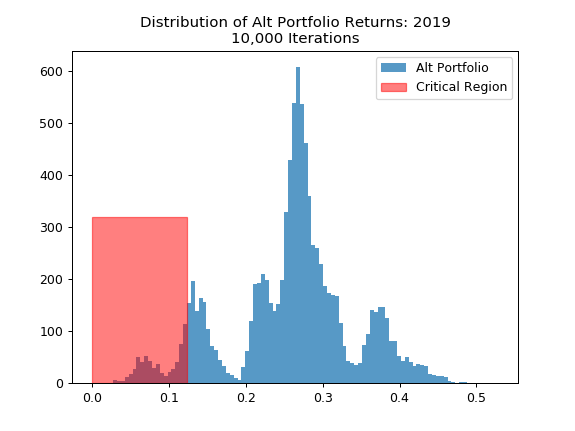

In [148]:
fig, ax = plt.subplots()
ax.hist(experiment_df['ALT'], bins=100, label='Alt Portfolio', alpha=0.75)
ax.axvspan(-0,hypothesis_df['lower'][0], ymin=0, ymax=0.5, alpha=0.5, color='red', label='Critical Region')
plt.title('Distribution of Alt Portfolio Returns: 2019\n{:,} Iterations'.format(n_loops))
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


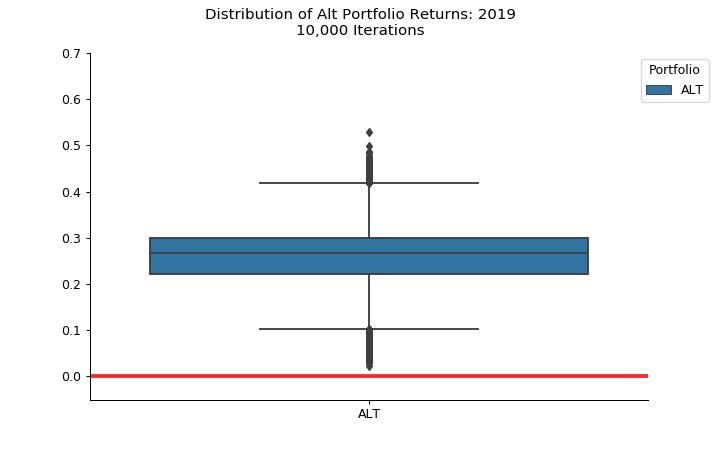

<IPython.core.display.Javascript object>


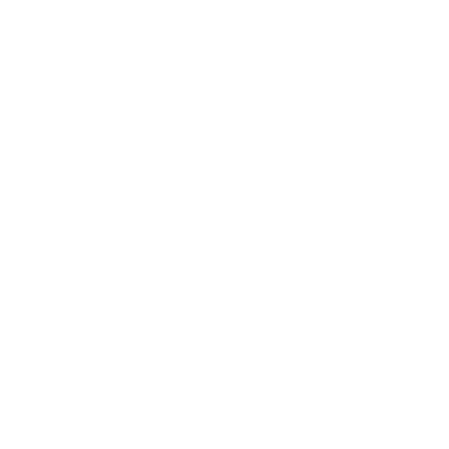

In [76]:
plot_boxplots(experiment_df)

### DID YOU RUN 10,000 ITERATIONS?

In [75]:
def plot_boxplots(df):
    fig, ax = plt.subplots(figsize=(8,5))
    
    temp_df = df.iloc[:, :-1]
    melted_df = pd.melt(df,value_vars=['ALT'],
                var_name = 'portfolio', value_name='returns')

    g = sns.catplot(ax=ax, data=melted_df, kind='box', x='portfolio', y='returns', hue='portfolio', legend=True, legend_out=True)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')        

    #ax.set_title('Samples={}, P_Size={}'.format(sample_size, p_size), fontsize=20)
    ax.tick_params(axis="x", rotation=0)
    #ax.axhline(return_sp19, color='red', alpha=0.7, label='SP500 2019/2020')
    #ax.axhline(return_sp20, color='red', alpha=0.7)
    ax.axhline(0, color='red', alpha=0.85, linewidth=3)
    ax.set_ylim(-0.05, 0.7)

    legend = ax.legend(loc='upper right', bbox_to_anchor=(1.12,1), title='Portfolio', fontsize=10)
    legend.get_title().set_fontsize('10')

    fig.suptitle('Distribution of Alt Portfolio Returns: 2019\n{:,} Iterations'.format(n_loops))
    #fig.text(0.5, 0.04, 'R Threshold', ha='center', va='center', fontsize=15)
    #fig.text(0.06, 0.5, 'Portfolio Return', ha='center', va='center', rotation=90, fontsize=15)
    fig.subplots_adjust(hspace=0.5)
    #plt.tight_layout()
    plt.close()
    plt.show()